# Build CNN on MNIST data with following features:
- data augmentation
- advance CNN architecture
- optimized on least model parameters with maximum accuracy

In [1]:
# Import Libraries

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
import warnings

# Ignore specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

---
---

## Notebook Summary:
1. **Target:** 
    - Increase model capacity but continue having total parameters under 8k
    - Include data augmentation like rotation, cutout and others
    - Fine tune learning rate and other parameter
2. **Results:** 
    - Parameters:  7,480
    - Best Training Accuracy: 98.84
    - Best Test Accuracy: 99.49
3. **Analysis:** 
    - Model achieved required accuracy with all constraints - Test Accuracy is consistently >99.4 from 5th Epochs reaching maximum of 99.49 in Epoch 14th! 
    - ReduceLROnPlateau helps in further increasing the accuracy when model stops learning, optimal placement of MaxPool have also helped the model to train better (it works better after RF=7 in this case)
    - Although we do find some under-fitting mostly because we have made out training data harder by using multiple data augmentation 
    - Model can be pushed further by updating Epochs and other parameters


---
---
## Hyperparameters

In [2]:
# Hyperparameters class for easy tuning
class HyperParameters:
    def __init__(self):
        self.num_epochs = 15
        self.batch_size = 64
        self.learning_rate = 0.03
        self.dropout_rate = 0.1
        self.num_classes = 10
        self.momentum = 0.95
        self.random_seed = 193

# Initialize hyperparameters
params = HyperParameters()
print(params.__dict__)

{'num_epochs': 15, 'batch_size': 64, 'learning_rate': 0.03, 'dropout_rate': 0.1, 'num_classes': 10, 'momentum': 0.95, 'random_seed': 193}


## Data Transformations & Tain/Test data loader

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random shifts
                                       transforms.RandomPerspective(distortion_scale=0.2, p=0.5), # Perspective changes
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [4]:
# Load MNIST dataset
train = datasets.MNIST('./../data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./../data', train=False, download=True, transform=test_transforms)

In [5]:
# Create data loaders

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(params.random_seed)

if cuda:
    torch.cuda.manual_seed(params.random_seed)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=params.batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=params.batch_size)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## CNN Model Architecture 

In [6]:
dropout_value = params.dropout_rate
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 22
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 7
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Summary

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = TinyCNN().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,152
           Conv2d-10           [-1, 12, 22, 22]             192
             ReLU-11           [-1, 12, 22, 22]               0
      BatchNorm2d-12           [-1, 12, 22, 22]              24
          Dropout-13           [-1, 12, 22, 22]               0
        MaxPool2d-14           [-1

## Train & Test Functions

In [8]:
# train

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

In [9]:
# test

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Run Model

In [10]:
# load Model

model =  TinyCNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.95)

In [11]:
EPOCHS = params.num_epochs
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.12628760933876038 Batch_id=937 Accuracy=89.45: 100%|██████████| 938/938 [00:33<00:00, 27.90it/s] 


Test set: Average loss: 0.0617, Accuracy: 9790/10000 (97.90%)
EPOCH: 1


Loss=0.05794757604598999 Batch_id=937 Accuracy=96.57: 100%|██████████| 938/938 [00:31<00:00, 29.48it/s] 


Test set: Average loss: 0.0405, Accuracy: 9867/10000 (98.67%)
EPOCH: 2


Loss=0.014188795350492 Batch_id=937 Accuracy=97.27: 100%|██████████| 938/938 [00:31<00:00, 29.37it/s]   


Test set: Average loss: 0.0376, Accuracy: 9869/10000 (98.69%)
EPOCH: 3


Loss=0.1896352767944336 Batch_id=937 Accuracy=97.46: 100%|██████████| 938/938 [00:31<00:00, 29.33it/s]   


Test set: Average loss: 0.0337, Accuracy: 9881/10000 (98.81%)
EPOCH: 4


Loss=0.05193864554166794 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:32<00:00, 29.04it/s] 


Test set: Average loss: 0.0367, Accuracy: 9881/10000 (98.81%)
EPOCH: 5


Loss=0.016850385814905167 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:31<00:00, 29.45it/s]


Test set: Average loss: 0.0341, Accuracy: 9893/10000 (98.93%)
EPOCH: 6


Loss=0.09448875486850739 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:31<00:00, 30.00it/s]  


Test set: Average loss: 0.0261, Accuracy: 9914/10000 (99.14%)
EPOCH: 7


Loss=0.16207580268383026 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:31<00:00, 30.04it/s]  


Test set: Average loss: 0.0282, Accuracy: 9907/10000 (99.07%)
EPOCH: 8


Loss=0.15163448452949524 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:31<00:00, 30.12it/s]  


Test set: Average loss: 0.0264, Accuracy: 9910/10000 (99.10%)
EPOCH: 9


Loss=0.003096642205491662 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:30<00:00, 30.40it/s] 


Test set: Average loss: 0.0254, Accuracy: 9916/10000 (99.16%)
EPOCH: 10


Loss=0.06862811744213104 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [00:31<00:00, 29.46it/s]  


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)
EPOCH: 11


Loss=0.0071774134412407875 Batch_id=937 Accuracy=98.28: 100%|██████████| 938/938 [00:31<00:00, 30.00it/s]


Test set: Average loss: 0.0258, Accuracy: 9922/10000 (99.22%)
EPOCH: 12


Loss=0.03111741691827774 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:31<00:00, 30.21it/s]  


Test set: Average loss: 0.0219, Accuracy: 9928/10000 (99.28%)
EPOCH: 13


Loss=0.006521611008793116 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:34<00:00, 27.46it/s] 


Test set: Average loss: 0.0212, Accuracy: 9930/10000 (99.30%)
EPOCH: 14


Loss=0.06067056581377983 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:33<00:00, 27.60it/s]  


Test set: Average loss: 0.0207, Accuracy: 9924/10000 (99.24%)


In [12]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [13]:
# Optimizing Learning rate
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
   optimizer,
   mode='max',           # Since we're tracking accuracy
   factor=0.1,          # Multiply lr by this factor when plateauing
   patience=1,          # Number of epochs to wait before reducing lr
   verbose=True,        # Print message when lr is reduced
   min_lr=1e-6         # Don't reduce lr below this value
)

EPOCHS = params.num_epochs
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    test(model, device, test_loader)
    scheduler.step(test_acc[-1])  # Using the latest test accuracy

EPOCH: 0


Loss=0.007235127501189709 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:31<00:00, 29.33it/s] 


Test set: Average loss: 0.0214, Accuracy: 9926/10000 (99.26%)
EPOCH: 1


Loss=0.08195382356643677 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:31<00:00, 29.76it/s]  


Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)
EPOCH: 2


Loss=0.019113652408123016 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:34<00:00, 26.82it/s] 


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)
EPOCH: 3


Loss=0.1462676227092743 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:34<00:00, 27.28it/s]   


Test set: Average loss: 0.0186, Accuracy: 9933/10000 (99.33%)
EPOCH: 4


Loss=0.2406560778617859 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:35<00:00, 26.37it/s]   


Test set: Average loss: 0.0173, Accuracy: 9942/10000 (99.42%)
EPOCH: 5


Loss=0.00850234180688858 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:35<00:00, 26.78it/s]  


Test set: Average loss: 0.0169, Accuracy: 9942/10000 (99.42%)
EPOCH: 6


Loss=0.0529954768717289 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:35<00:00, 26.35it/s]   


Test set: Average loss: 0.0165, Accuracy: 9944/10000 (99.44%)
EPOCH: 7


Loss=0.08849956095218658 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:34<00:00, 27.29it/s]  


Test set: Average loss: 0.0162, Accuracy: 9947/10000 (99.47%)
EPOCH: 8


Loss=0.036659304052591324 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:34<00:00, 27.58it/s] 


Test set: Average loss: 0.0171, Accuracy: 9942/10000 (99.42%)
EPOCH: 9


Loss=0.005611976608633995 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:33<00:00, 27.60it/s] 


Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.44%)
EPOCH: 10


Loss=0.014347116462886333 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:33<00:00, 27.67it/s] 


Test set: Average loss: 0.0164, Accuracy: 9946/10000 (99.46%)
EPOCH: 11


Loss=0.027322426438331604 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:34<00:00, 27.44it/s] 


Test set: Average loss: 0.0173, Accuracy: 9940/10000 (99.40%)
EPOCH: 12


Loss=0.08455619215965271 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:33<00:00, 27.68it/s]  


Test set: Average loss: 0.0160, Accuracy: 9947/10000 (99.47%)
EPOCH: 13


Loss=0.08458726853132248 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:33<00:00, 27.69it/s]  


Test set: Average loss: 0.0159, Accuracy: 9948/10000 (99.48%)
EPOCH: 14


Loss=0.013432100415229797 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:33<00:00, 27.72it/s] 


Test set: Average loss: 0.0161, Accuracy: 9949/10000 (99.49%)


In [ ]:
# # Optimizing Learning rate
# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

# EPOCHS = params.num_epochs
# for epoch in range(EPOCHS):
#     print("EPOCH:", epoch)
#     train(model, device, train_loader, optimizer)
#     scheduler.step()
#     test(model, device, test_loader)

In [26]:
# # Optimizing Learning rate
# from torch.optim.lr_scheduler import OneCycleLR
# scheduler = OneCycleLR(
#    optimizer,
#    max_lr=0.02,  # Maximum learning rate
#    epochs=params.num_epochs,
#    steps_per_epoch=len(train_loader),
#    pct_start=0.3,  # Percentage of training to increase lr
#    anneal_strategy='cos'  # Cosine annealing
# )

# EPOCHS = params.num_epochs
# for epoch in range(EPOCHS):
#    print("EPOCH:", epoch)
#    train(model, device, train_loader, optimizer)
#    scheduler.step()  # Step the scheduler
#    test(model, device, test_loader)

> Test Accuracy is consistently >99.4 from 5th Epochs reaching maximum of 99.48 in Epoch 14th!

## Plots

In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Calculate epoch-level training accuracy
train_acc_epoch = [98.42,	98.42,	98.37,	98.44,	98.74,	98.78,	98.77,	98.78,	98.82,
                   98.79,	98.83,	98.80,	98.84,	98.81,	98.83]
# for i in range(0, len(train_acc), len(train_loader)):
#    train_acc_epoch.append(train_acc[i])
# Create figure
fig = go.Figure()
# Add traces for training and test accuracy
fig.add_trace(
   go.Scatter(
       x=list(range(1, params.num_epochs + 1)),
       y=train_acc_epoch,
       mode='lines+markers',
       name='Train Accuracy',
       line=dict(color='blue')
   )
)
fig.add_trace(
   go.Scatter(
       x=list(range(1, params.num_epochs + 1)),
       y=test_acc,
       mode='lines+markers',
       name='Test Accuracy',
       line=dict(color='red')
   )
)
# Update layout
fig.update_layout(
   title='Model Accuracy per Epoch',
   xaxis_title='Epochs',
   yaxis_title='Accuracy (%)',
   hovermode='x unified',
   template='plotly_white',
   width=1000,
   height=600
)
# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.show()

Text(0.5, 1.0, 'Test Accuracy')

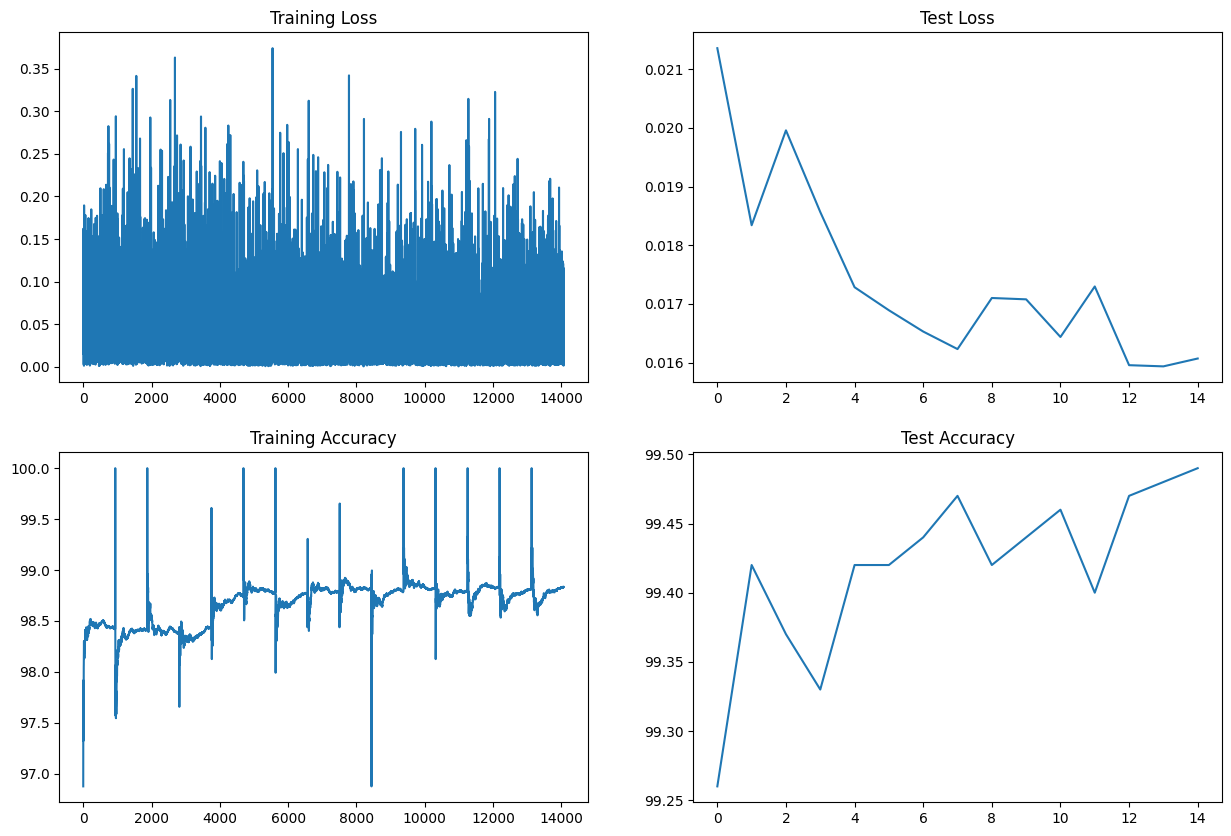

In [23]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

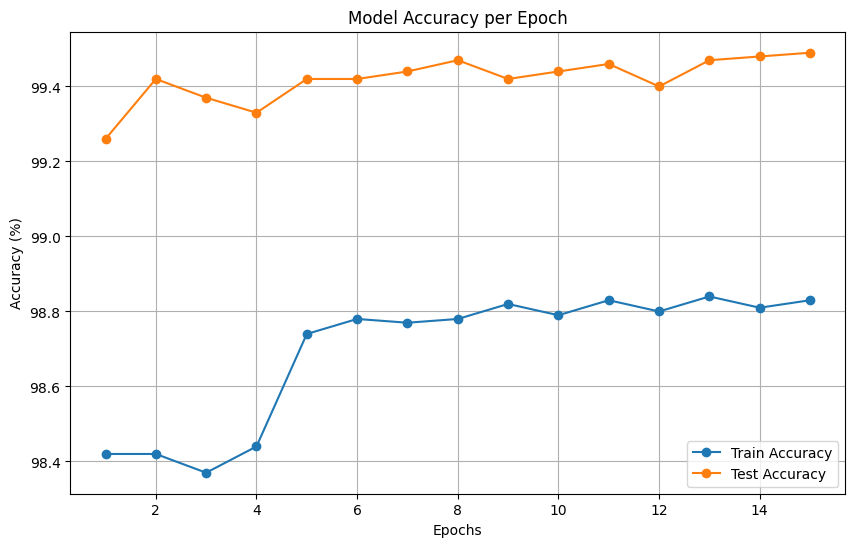

In [24]:
# Calculate epoch-level training accuracy
# train_acc_epoch = []
# for i in range(0, len(train_acc), len(train_loader)):  # len(train_loader) = 938
#    train_acc_epoch.append(train_acc[i])
plt.figure(figsize=(10,6))
plt.plot(range(1, params.num_epochs + 1), train_acc_epoch, label='Train Accuracy', marker='o')
plt.plot(range(1, params.num_epochs + 1), test_acc, label='Test Accuracy', marker='o')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
